Consider a TF Ising 1D spin chain with periodic boundary conditions consisting of $n=6$ spins:
$$
H(h) = \sum_{\langle i, j \rangle}^n Z_i Z_j + h \sum_{i=1}^n X_i.
$$

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import expm
import qit
from qutip import *

In [10]:
# Define 1-qubit Pauli operators

I = qit.lmap(np.array([[1, 0], [0, 1]]))
X = qit.lmap(np.array([[0, 1], [1, 0]]))
Z = qit.lmap(np.array([[1, 0], [0, -1]]))

In [11]:
# Define 6-qubit Pauli operators

X_1 = qit.tensor(X,I,I,I,I,I)
X_2 = qit.tensor(I,X,I,I,I,I)
X_3 = qit.tensor(I,I,X,I,I,I)
X_4 = qit.tensor(I,I,I,X,I,I)
X_5 = qit.tensor(I,I,I,I,X,I)
X_6 = qit.tensor(I,I,I,I,I,X)

Z_1 = qit.tensor(Z,I,I,I,I,I)
Z_2 = qit.tensor(I,Z,I,I,I,I)
Z_3 = qit.tensor(I,I,Z,I,I,I)
Z_4 = qit.tensor(I,I,I,Z,I,I)
Z_5 = qit.tensor(I,I,I,I,Z,I)
Z_6 = qit.tensor(I,I,I,I,I,Z)

In [12]:
# Define 1-D quantum Ising Hamiltonian on a ring

def H(h):
    tmp_1 = h * (X_1.data + X_2.data + X_3.data + X_4.data + X_5.data + X_6.data)
    tmp_2 = Z_1.data @ Z_2.data
    tmp_3 = Z_2.data @ Z_3.data
    tmp_4 = Z_3.data @ Z_4.data
    tmp_5 = Z_4.data @ Z_5.data
    tmp_6 = Z_5.data @ Z_6.data
    tmp_7 = Z_6.data @ Z_1.data
    return tmp_1 + tmp_2 + tmp_3 + tmp_4 + tmp_5 + tmp_6 + tmp_7

Let us split the system into three subsystems which are $A, B, C$.
</br> <br>
$$
A=\{1,3,5\}
$$
$$
B=\{2,4\}
$$
$$
C=\{6\}
$$

We want to show numerically for $h \in [-1, 1]$, $\beta \in [1, 10]$ that, 
in a thermal state with inverse temperature $\beta$
$$
\rho = \frac{e^{-\beta H}}{\mathrm{Tr} (e^{-\beta H})} \equiv \rho_{ABC}
$$
the strong subadditivity of entropy is not violated. That is, plot the quantity
$$
f = S(AB) + S(BC) - S(ABC) - S(B)
$$
as a heatmap versus $h$ and $\beta$, it should be non-negative.

For our calculations we will need the following matrices:
$$\rho_{AB}=Tr_C(\rho_{ABC})$$
$$\rho_{BC}=Tr_A(\rho_{ABC})$$
$$\rho_{B}=Tr_{AC}(\rho_{ABC})$$

In [13]:
# Define thermal state with inverse temperature beta

def rho(h, beta):
    tmp_1 = scipy.linalg.expm(- beta * H(h))
    tmp_2 = np.trace(tmp_1)
    return tmp_1 / tmp_2

In [16]:
def rho_qutip(h, beta):
    return Qobj(rho(h, beta), dims=[[2,2,2,2,2,2],[2,2,2,2,2,2]])

In [17]:
def rho_ab(h, beta):
    return rho_qutip(h, beta).ptrace([0,1,2,3,4])

def rho_bc(h, beta):
    return rho_qutip(h, beta).ptrace([1,3,5])

def rho_b(h, beta):
    return rho_qutip(h, beta).ptrace([1,3])

def rho_abc(h, beta):
    return rho_qutip(h, beta)

In [18]:
%%time
h = np.linspace(-1,1,1000)
beta = np.linspace(1,10,1000)
f = np.zeros((len(h), len(beta)))

# f = S(AB) + S(BC) - S(ABC) - S(B)
for i in range(len(h)):
    for j in range(len(beta)):
        f[i,j] = entropy_vn(rho_ab(h[i], beta[j]), base=2.718281828459045, sparse=False) + entropy_vn(rho_bc(h[i], beta[j]), base=2.718281828459045, sparse=False) - entropy_vn(rho_abc(h[i], beta[j]), base=2.718281828459045, sparse=False) - entropy_vn(rho_b(h[i], beta[j]), base=2.718281828459045, sparse=False)

Wall time: 5h 29min 2s


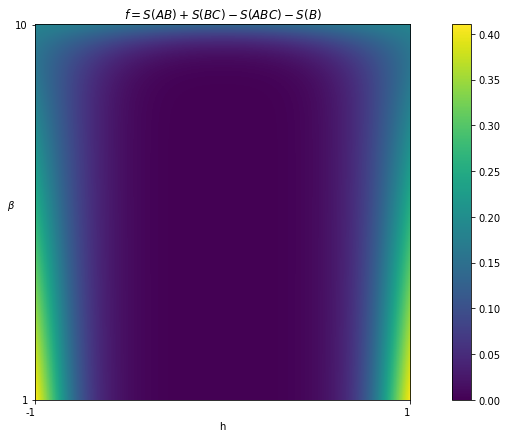

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(f.T)
ax.set_xticks([0,len(h)-1])
ax.set_yticks([0,len(beta)-1])
ax.set_xticklabels(['-1','1'])
ax.set_yticklabels(['10','1'])
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
ax.set_title('$f = S(AB) + S(BC) - S(ABC) - S(B)$')
fig.tight_layout()
cbar = ax.figure.colorbar(im, ax=ax)
plt.xlabel('h')
plt.ylabel('$β$', rotation=0)
plt.show()

As we can see, the non-negativity of $f$ is a numerical proof of strong subadditivity of quantum Shannon's entropy.